In [ ]:
import numpy as np
import datetime
import pandas as pd
import json
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import neighbors, datasets, model_selection

##Functions

In [ ]:
def entropy(Y):
    e = 0
    classes, counts = np.unique(Y, return_counts=True) #this is expensive / not optimized
    for count in counts:
        prob = count/len(Y)
        e += prob * np.log2(prob)
    return e*(-1)

def gini(Y): #formula according to slide 12/23 from lecture 05
    g = 0
    classes, counts = np.unique(Y, return_counts=True) #this is expensive / not optimized
    for count in counts:
        g += count/len(Y) * (1-count/len(Y))
    return g

def conditionalEntropy(partA, partA_Y, partB, partB_Y):
    lenY = len(Y)
    return len(partA)/lenY * entropy(partA_Y) + len(partB)/lenY * entropy(partB_Y)

def conditionalGini(partA, partA_Y, partB, partB_Y):
    lenY = len(Y)
    return len(partA)/lenY * gini(partA_Y) + len(partB)/lenY * gini(partB_Y)

def splitByThreshold(data, column, threshold): #this is expensive / not optimized
        maskA = data[:, column] < threshold
        maskB = data[:, column] >= threshold
        dataA = data[maskA, :]
        dataB = data[maskB, :]
        partA, partA_Y = dataA[:,0:10], dataA[:,10]
        partB, partB_Y = dataB[:,0:10], dataB[:,10]
        return partA, partA_Y, partB, partB_Y

def buildTree(X, y, tree, curr, measure="entropy"):
    #If all data points have the same label - return leaf with this label
    uniqueX, uniqueY = np.unique(X), np.unique(y, return_counts=True)
    if len(uniqueY[0]) == 1:
        tree.update({curr : y[0]})
        return
    #Else if all data points have identical feature values - return leaf with most common label
    if len(uniqueX) == 1:
        vars, counts = uniqueY
        tree.update({curr : vars[counts.index(np.max(counts))]})
        return
    #Else
    data = np.hstack((X,y.reshape(-1,1))) #combine x and y for sorting 
    maxGainOverall = [0,0,0]
    entropyY = entropy(y)
    giniY = gini(y)
    for i in range(0,X.shape[1]):
        maxGainInCol = [0,0,0]
        data[data[:, i].argsort()] #sort by column i
        for j in range(0,X.shape[0]-1):
            threshold = (data[j, i] + data[j+1, i])/2 #split between two adjacent datapoints
            partA, partA_Y, partB, partB_Y = splitByThreshold(data, i, threshold)
            if measure == "entropy":
                gain = entropyY - conditionalEntropy(partA, partA_Y, partB, partB_Y)
            elif measure == "gini":
                gain = giniY - conditionalGini(partA, partA_Y, partB, partB_Y)
            else:
                raise Exception("invalid impurity measure, choose 'entropy' or 'gini'")
            maxGainInCol = np.array([i,threshold, gain]) if gain > maxGainInCol[2] else maxGainInCol
        maxGainOverall = maxGainInCol if maxGainInCol[2] > maxGainOverall[2] else maxGainOverall

    column, thres, gain = int(maxGainOverall[0]), maxGainOverall[1], maxGainOverall[2]
    partA, partA_Y, partB, partB_Y = splitByThreshold(data, column, thres)
    tree.update({curr : (thres, column)})
    buildTree(partA, partA_Y, tree, (2*curr)+1, measure)
    buildTree(partB, partB_Y, tree, (2*curr)+2, measure)

def learn(X, y, skips=True, impurity_measure='entropy', prune=False):
    #'_int' refers to internal
    tree_int, X_int, y_int = {}, X, y
    a = datetime.datetime.now()
    if prune:
        seed = 777                 
        X_train_int, X_prune_int, Y_train_int, Y_prune_int = train_test_split(X_int, y_int, test_size= 0.2, shuffle=True, random_state=seed)
        buildTree(X,y, tree_int, 0, measure=impurity_measure)
        pruneTree(tree_int, X_prune_int, Y_prune_int)
    else:
        buildTree(X_int,y_int, tree_int, 0, measure=impurity_measure)

    tree_file = open("tree.json", "w")
    json.dump(tree_int, tree_file)
    tree_file.close()
    b = datetime.datetime.now()
    c = b - a
    print("took: " +str(c.total_seconds()) + " seconds")
    return tree_int

def predict(X_val, tree):
    result = []
    for x in X_val:
        currentPosition = 0 #always start at the root
        Node = tree[currentPosition]
        while type(Node) == type(tuple(("any", "thing"))):
            threshold, column = Node[0], Node[1] #every node contains the column and threshold determining the split / decision
            currentPosition = (2*currentPosition)+1 if x[column] < threshold else (2*currentPosition)+2 #go to left or right child
            Node = tree[currentPosition]
        result.append(Node) #if the node is a leaf it only contains the label
    return result

#recursively counts how often which label occurs in the subtree - only works for two classes!
def labelCounts(tree, index, count, Y):
    if tree.get(index) not in np.unique(Y):
        if tree.get(2*index+1):
            labelCounts(tree, 2*index +1 , count, Y)
        if tree.get(2*index+2):
            labelCounts(tree, 2*index +2 , count, Y)
    else:
        if tree.get(index) != -1:
            if tree.get(index) in np.unique(Y)[0]:
                count[0] += 1
            else:
                count[1] += 1
        else:
            raise Exception("Index Issue in labelCounts")
    return count

#recursively deletes the nodes in a subtree (discarded while pruning)
def purgeSubtree(tree, index):
    if tree.get(2*index+1): #if node has left child, delete it call again for possible subtree of the left child
        tree.pop(2*index+1)
        purgeSubtree(tree, 2*index +1)
    if tree.get(2*index+2): #if node has right child, delete it and call again for possible subtree of the right child
        tree.pop(2*index+2)
        purgeSubtree(tree, 2*index +2 )

def pruneTree(tree, X_prune, Y_prune):
    nodes = list(tree.keys())
    subtrees = [i for i in nodes if type(tree.get(i)) != type("string")]
    subtrees.sort()
    subtrees.reverse()

    for i in subtrees:
        Y_pred = predict(X_prune, tree)
        correct = [Y_pred == Y_prune]
        accuracy = np.sum(correct)/len(Y_pred) #compute accuracy before pruning
        counts = labelCounts(tree, i, [0,0], Y_prune)
        labels = np.unique(Y)
        commonLabel = labels[counts.index(max(counts))] #find most common label in the subtree
        oldValue = tree.get(i)
        tree.update({i : commonLabel})         #change tree leaf at given key to most common label
        Y_pred_pruned = predict(X_prune, tree)
        correctPruned = [Y_pred_pruned == Y_prune]
        accuracyPruned = np.sum(correctPruned)/len(Y_pred_pruned) #compute accuracy after pruning

        if accuracyPruned < accuracy: #reverse modification if pruning didnt impove the accuracy
            tree.update({i : oldValue})
        else:
            purgeSubtree(tree, i) #delete the original subtree of the modified node (now leaf)

#assuming hadrons are positive, gamma is negative
#only works for this dataset (unsure if generalization is required)
#only works for binary classification
def score(Y, Y_pred, printValues=True, confusion=True): 
    truePredictions = [Y_pred == Y]
    truePositives, falsePositives, falseNegatives, trueNegatives = 0,0,0,0
    for i in range(0,len(Y_pred)):
        if Y_pred[i] == "h" and Y[i] == "h":
            truePositives += 1
        elif Y_pred[i] == "h" and Y[i] == "g":
            falsePositives += 1
        elif Y_pred[i] == "g" and Y[i] == "h":
            falseNegatives += 1
        elif Y_pred[i] == "g" and Y[i] == "g":
            trueNegatives += 1
    accuracy  = np.sum(truePredictions)/len(Y)
    precision = truePositives / (truePositives + falsePositives)
    recall    = truePositives / (truePositives + falseNegatives)
    f2 = 2*(precision*recall) / (precision+recall)
    if confusion:
        array = [[truePositives,falsePositives],
                [falseNegatives,trueNegatives]]
        df = pd.DataFrame(array, index=["Hadron (pred)", "Gamma (pred)"], columns=["Hadron (truth)", "Gamma (truth"])
        plt.figure(figsize=(5.5,4))
        sn.heatmap(df, annot=True, annot_kws={"size": 8})
        plt.show()
    if printValues:
        print("accuracy: " + str(accuracy))   #percentage of correct predictions
        print("recall: " + str(recall))       #how many of the positives it found in percent
        print("precision: " + str(precision)) #percentage of actually positives out of the positive-predicted
        print("f2 score: " + str(f2))
    return accuracy, precision, recall, f2



##1.4 Evaluate your algorithm

Assess the performance of your algorithm using an appropriate performance measure. 

- Which setting should you select for this data (entropy or
gini, pruning or no pruning)? 

- What is your estimate for the performance of
the selected model on unseen data points? 

- Report how you arrived at the conclusions.

Remember to use training, validation, and test sets properly. Note that
in the model selection step you select one out of the four models (settings)
based on performance on validation data and in the model evaluation step
you evaluate the selected model on test data.

 ============ Split datasets ============
Datapoints used for training:    11411
Datapoints used for validation:  3804
Datapoints used for testing :    3804

 ============ Evaluation on validation data ============

impurity_measure=gini, pruning=False
took: 2609.776061 seconds
number of nodes: 2747


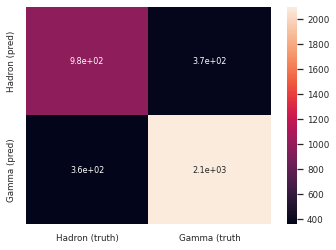

accuracy: 0.8086225026288117
recall: 0.7340823970037453
precision: 0.7243163340724317
f2 score: 0.7291666666666667

impurity_measure=gini, pruning=True
took: 2669.407901 seconds
number of nodes: 1425


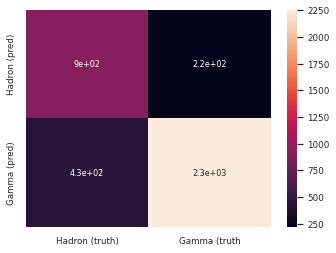

accuracy: 0.8291272344900105
recall: 0.6749063670411986
precision: 0.8066248880931065
f2 score: 0.734910277324633

impurity_measure=entropy, pruning=False
took: 2286.262893 seconds
number of nodes: 2487


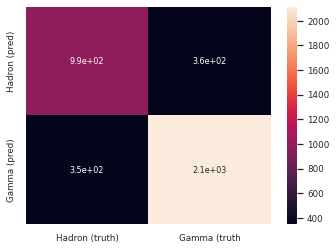

accuracy: 0.8151945320715037
recall: 0.7400749063670412
precision: 0.7351190476190477
f2 score: 0.7375886524822696

impurity_measure=entropy, pruning=True
took: 2414.720866 seconds
number of nodes: 1495


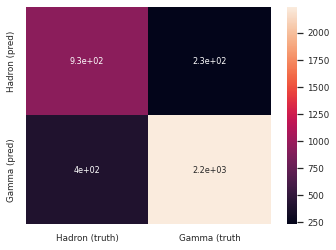

accuracy: 0.833596214511041
recall: 0.699625468164794
precision: 0.8010291595197255
f2 score: 0.7469012395041984


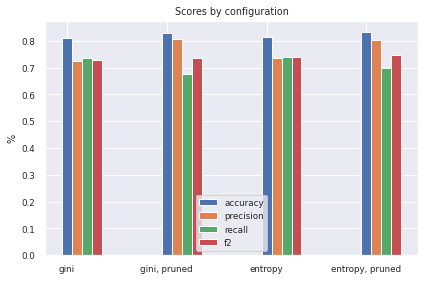

In [ ]:
data = pd.read_csv("magic04.data", delimiter=",")
npdata = data.to_numpy()
#X, Y = npdata[11000:13000,0:10], npdata[11000:13000:,10] #smaller dataset for testing functionality during development
X, Y = npdata[:,0:10], npdata[:,10]

print(" ============ Split datasets ============")
seed = 666                   
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.4, shuffle=True, random_state=seed)
seed = 221
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size= 0.5, shuffle=True, random_state=seed) 
#Test data is not used in this cell

# Store number of datapoints in each dataset:
print("Datapoints used for training:   ", len(Y_train))
print("Datapoints used for validation: ", len(X_val))
print("Datapoints used for testing :   ", len(X_test))

print("\n ============ Evaluation on validation data ============")
measures, pruning = ["gini", "entropy"], [False, True]
acc, prec, rec, f2collected = [], [], [], []

for i in range(0,2):
    for j in range(0,2):
        print("\nimpurity_measure=" + measures[i] + ", pruning=" + str(pruning[j]))
        tree = learn(X_train,Y_train, impurity_measure=measures[i], prune=pruning[j])
        print("number of nodes: " + str(len(tree)))
        Y_pred = predict(X_val, tree)
        accuracy, precision, recall, f2 = score(Y_val, Y_pred, printValues=True, confusion=True)
        acc.append(accuracy)
        prec.append(precision)
        rec.append(recall)
        f2collected.append(f2)

#plotting the calculated scores in a bar chart
labels = ['gini', 'gini, pruned', 'entropy', 'entropy, pruned']
x = np.arange(len(labels))
width = 0.1
fig, ax = plt.subplots()
barOne = np.arange(len(acc))
barTwo = [x + width for x in barOne]
barThree = [x + width for x in barTwo]
barFour = [x + width for x in barThree]
rects1 = ax.bar(barOne, acc, width, label='accuracy')
rects2 = ax.bar(barTwo, prec, width, label='precision')
rects3 = ax.bar(barThree, rec, width, label='recall')
rects4 = ax.bar(barFour, f2collected, width, label='f2')
ax.set_ylabel('%')
ax.set_title('Scores by configuration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

##1.5 Testing & Comparison to an existing implementation

Compare your implementation to some existing decision tree implementation.
- How does your implementation fare against this implementation in terms of accuracy and speed? 
- Can you explain the (possible) differences?

Note: You can compare to, for example, DecisionTreeClassifier from
sklearn

 ============ Split datasets ============
Datapoints used for training:    11411
Datapoints used for validation:  3804
Datapoints used for testing :    3804

 ============ SKLEARN ============
took: 0.221942 seconds


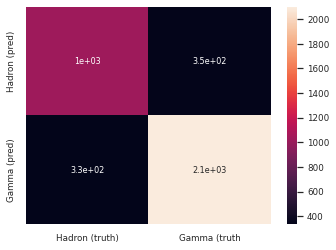

accuracy: 0.8212407991587802
recall: 0.7542310522442973
precision: 0.7476294675419402
f2 score: 0.750915750915751

 ============ CUSTOM IMPLEMENTATION ============
took: 2401.020481 seconds


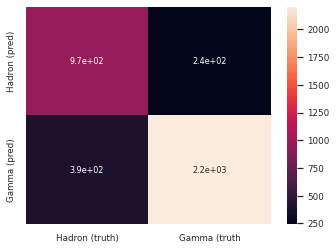

accuracy: 0.8343848580441641
recall: 0.7144959529065489
precision: 0.8004946413849959
f2 score: 0.7550544323483669


(0.8343848580441641,
 0.8004946413849959,
 0.7144959529065489,
 0.7550544323483669)

In [ ]:
data = pd.read_csv("magic04.data", delimiter=",")
npdata = data.to_numpy()
X, Y = npdata[:,0:10], npdata[:,10]

print(" ============ Split datasets ============")
seed = 666                   
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.4, shuffle=True, random_state=seed)
seed = 221
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size= 0.5, shuffle=True, random_state=seed) 
#Validation data is not used in this cell

# Store number of datapoints in each dataset:
print("Datapoints used for training:   ", len(Y_train))
print("Datapoints used for validation: ", len(X_val))
print("Datapoints used for testing :   ", len(X_test))

print("\n ============ SKLEARN ============")
clf = DecisionTreeClassifier(random_state=0)
a = datetime.datetime.now()
clf.fit(X_train, Y_train.reshape(-1,1),)
b = datetime.datetime.now()
print("took: " +str((b-a).total_seconds()) + " seconds")
Y_pred = clf.predict(X_test)
score(Y_test, Y_pred, True, True)

print("\n ============ CUSTOM IMPLEMENTATION ============")
tree = learn(X_train,Y_train, skips=True, impurity_measure="entropy", prune=True)
Y_pred = predict(X_test, tree)
score(Y_test, Y_pred, printValues=True, confusion=True)